# Vizualizacija
Izrisani so isti prstni odtisi kot v zvezku '020-fingerprints.ipynb' s podatki iz datoteke 'BBBP.csv'. Dodana sta še avtokodirnik in variacijski avotokodirnik katerih latentni prostora je enak 2. Torej za njiju ni bilo potrebno manjšanje dimenzij.
Pod grafi so izpisane AUR ROC vrednosti v kombinaciji metod najbližjih sosedov in "leave one out" v enakem vrstnem redu kot so izrisani grafi.

In [35]:
import numpy as np
import sys
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.model_selection import LeaveOneOut
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
sys.path.insert(0, '../code')
import cheauder_utils
from vae_smiles import CustomVariationalLayer


pca_n_comp = 20
tsne_n_com = 2
perp = 30
n_iter = 500

alpha = .3
markersize = 4

def one_out_accuracy(X, y, classifier=neighbors.KNeighborsClassifier()):
    predictions = np.zeros(len(y))
    loo = LeaveOneOut()
    for train_index, test_index in loo.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        predictions[test_index] = classifier.fit(X_train, y_train).predict(X_test)
    return roc_auc_score(y, predictions)
    
def do_plt(name,X, y, plt, title, legend):
    if name.lower()=='umap':
        u = umap.UMAP()
        res = u.fit_transform(X)
    elif name.lower()=='tsne':
        pca = PCA(n_components=pca_n_comp)
        pca_res = pca.fit_transform(X)
        tsne = TSNE(n_components=tsne_n_com, verbose=0, perplexity=perp, n_iter=n_iter)
        res = tsne.fit_transform(pca_res)
    elif name.lower()=='':
        res = X
    else:
        return None

    for yi in np.unique(y):
        plt.plot(np.array(res[:, 0])[y == yi], np.array(res[:, 1])[y == yi], 'o', label=str(yi), alpha=alpha,
                 markersize=markersize)
    plt.title(title)
    plt.xlabel('UMAP 1. komponenta')
    plt.ylabel('UMAP 2. komponenta')
    plt.legend(title=legend)
    return res


vae_encoder = cheauder_utils.load_coder_json("../code/model/encoder_2.json",
                                         "../code/weights/encoder_2_weights.h5",
                                         custom_objects={'CustomVariationalLayer': CustomVariationalLayer,
                                                  'latent_dim': 2})

ae_encoder = cheauder_utils.load_coder_json("../code/model/ae_encoder_2.json",
                                         "../code/weights/ae_encoder_2_weights.h5",
                                         custom_objects={'latent_dim': 2})

smiles, y, label = cheauder_utils.read_data('../data/BBBP.csv', col_smiles=3, col_target=2, delimiter=',')
fps, y, valid = cheauder_utils.smiles_to_fingerprints(smiles, y)
chars,charset = cheauder_utils.load_charset('../code/model/charset_ZINC.json')
oh_sms = cheauder_utils.vectorize_smiles(smiles, charset, 120)
vae,_,_ = vae_encoder.predict(oh_sms)
ae = ae_encoder.predict(oh_sms)

ae, vae = ae[valid], vae[valid]

## TSNE vizualizacije prstnih odtisov in vizualizacija 2d latentnega prostora avtokodirnika in variacijskega avtokodirnika

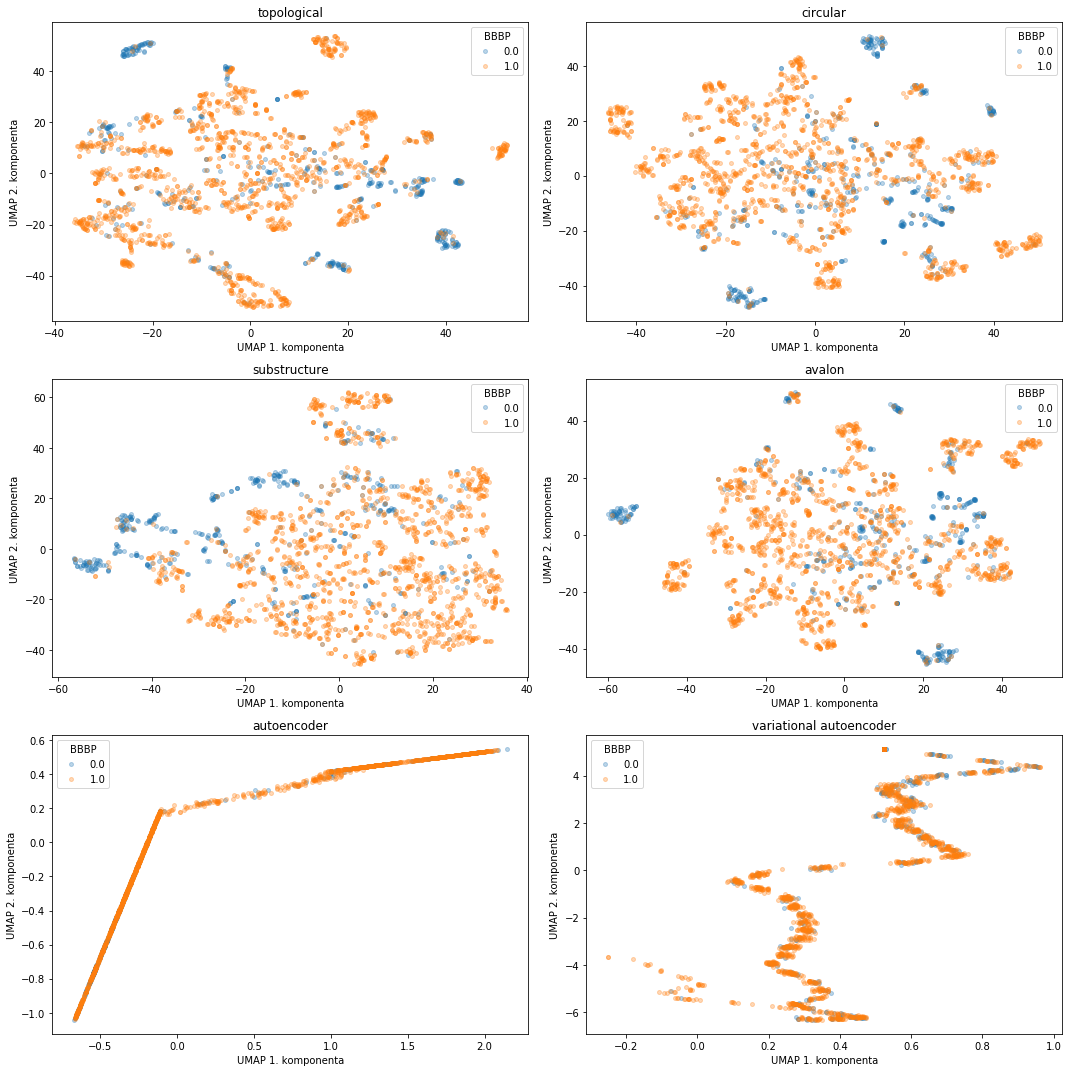

[0.7922213050830651, 0.7968797317903956, 0.8080377122857043, 0.793825926392436, 0.5779263066776366, 0.6601432166392864]


In [39]:
plt.rcParams['figure.figsize'] = [15, 15]
ts = list()
for i, (key, value) in enumerate(fps.items(), 1):
    plt.subplot(3, 2, i)
    t = do_plt('tsne', value, y, plt, key, 'BBBP')
    ts.append(one_out_accuracy(t, y))

plt.subplot(3, 2, 5)
t = do_plt('', ae, y, plt, 'autoencoder', 'BBBP')
ts.append(one_out_accuracy(t, y))

plt.subplot(3, 2, 6)
t = do_plt('', vae, y, plt, 'variational autoencoder', 'BBBP')
ts.append(one_out_accuracy(t, y))

plt.tight_layout()
plt.show()

print(ts)

## UMAP vizualizacije prstnih odtisov in vizualizacija 2d latentnega prostora avtokodirnika in variacijskega avtokodirnika

c:\users\repair\miniconda3\envs\mag-env\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components
c:\users\repair\miniconda3\envs\mag-env\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


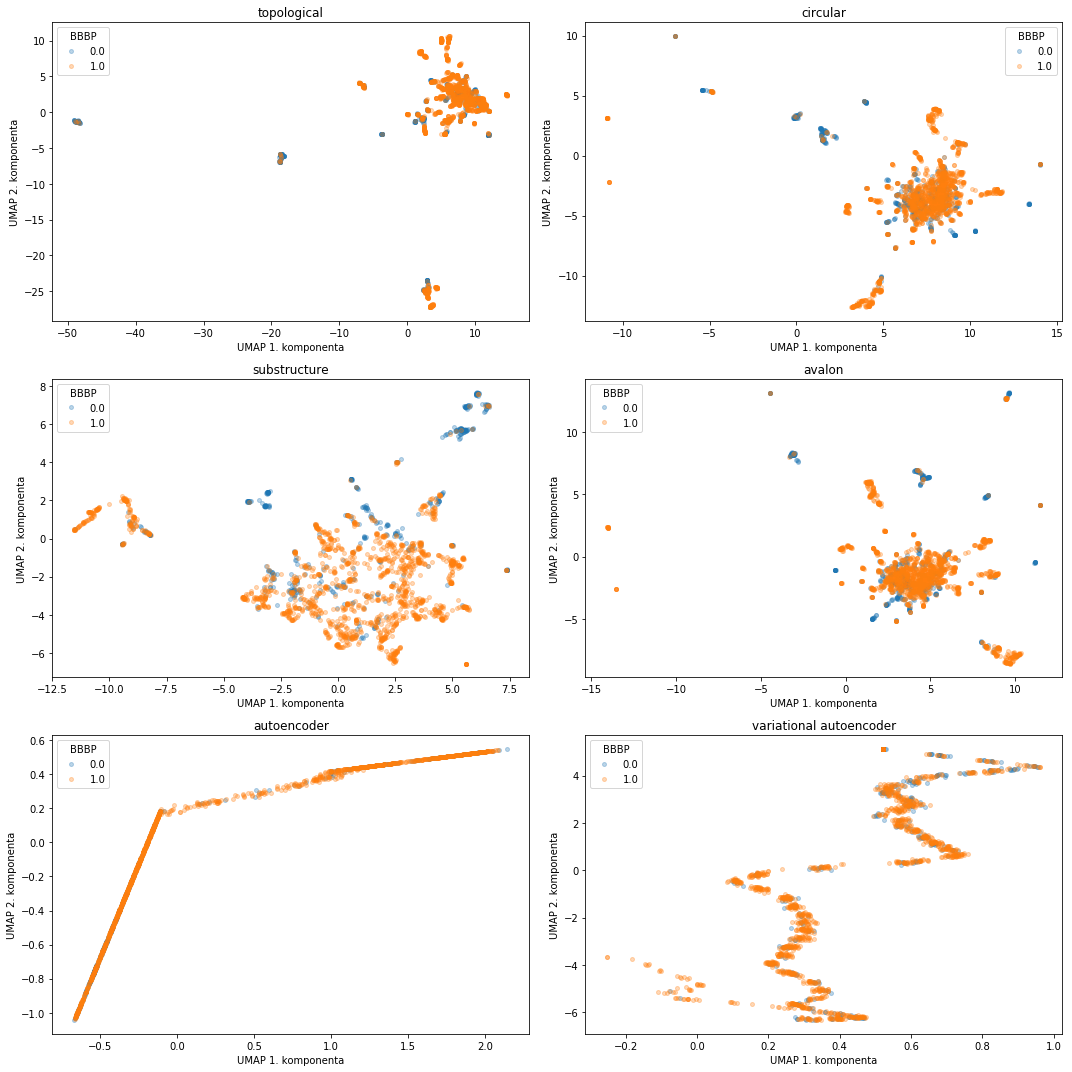

[0.8021766570813713, 0.7442046036216874, 0.8073147952114617, 0.7573725481788387, 0.5779263066776366, 0.6601432166392864]


In [41]:
plt.rcParams['figure.figsize'] = [15, 15]
ts = list()
for i, (key, value) in enumerate(fps.items(), 1):
    plt.subplot(3, 2, i)
    t = do_plt('umap', value, y, plt, key, 'BBBP')
    ts.append(one_out_accuracy(t, y))

plt.subplot(3, 2, 5)
t = do_plt('', ae, y, plt, 'autoencoder', 'BBBP')
ts.append(one_out_accuracy(t, y))

plt.subplot(3, 2, 6)
t = do_plt('', vae, y, plt, 'variational autoencoder', 'BBBP')
ts.append(one_out_accuracy(t, y))

plt.tight_layout()
plt.show()

print(ts)